[2024-11-29 03:56:42,028] INFO: Original Label Distribution: Counter({0: 1245, 1: 356})
[2024-11-29 03:56:42,965] INFO: Balanced Label Distribution: Counter({0: 1245, 1: 1245})


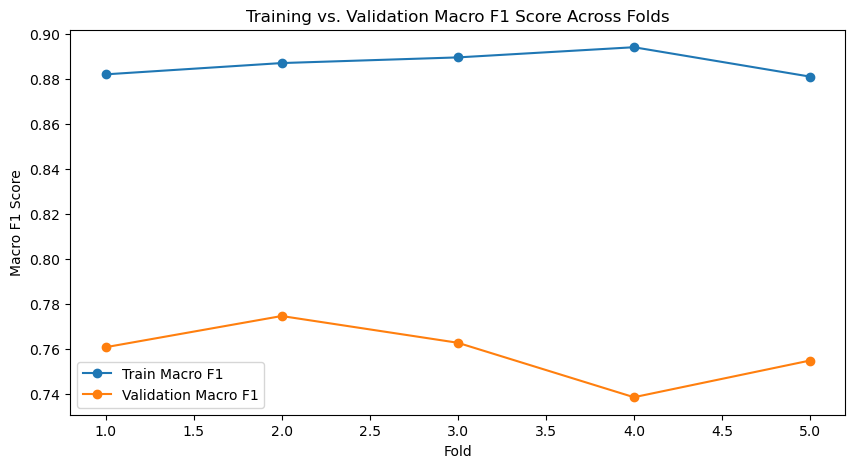

[2024-11-29 03:56:43,768] INFO: Mean Training Macro F1: 0.887
[2024-11-29 03:56:43,769] INFO: Mean Validation Macro F1: 0.758
[2024-11-29 03:56:44,146] INFO: Saved predictions to submission.csv


In [1]:
import pandas as pd
import numpy as np
import logging
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from collections import Counter
import warnings

logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')
logger = logging.getLogger(__name__)

def load_and_preprocess_data():
    data = pd.read_csv('train.csv')
    logger.info("Original Label Distribution: %s", Counter(data['LABEL']))

    tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))  
    X_tfidf = tfidf.fit_transform(data['TEXT']).toarray()
    y = data['LABEL']

    smote = SMOTE()
    X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)
    logger.info("Balanced Label Distribution: %s", Counter(y_resampled))

    return X_resampled, y_resampled, tfidf

def build_model():
    model = LogisticRegression(class_weight='balanced', max_iter=500, C=0.001)  
    return model

def train_and_evaluate():
    X_resampled, y_resampled, tfidf = load_and_preprocess_data()

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    train_scores = []
    val_scores = []

    for train_index, val_index in skf.split(X_resampled, y_resampled):
        X_train, X_val = X_resampled[train_index], X_resampled[val_index]
        y_train, y_val = y_resampled[train_index], y_resampled[val_index]

        pipeline = Pipeline([
            ('scaler', StandardScaler()),  
            ('clf', build_model())
        ])

        pipeline.fit(X_train, y_train)

        y_train_pred = pipeline.predict(X_train)
        y_val_pred = pipeline.predict(X_val)

        train_f1 = f1_score(y_train, y_train_pred, average='macro')
        val_f1 = f1_score(y_val, y_val_pred, average='macro')

        train_scores.append(train_f1)
        val_scores.append(val_f1)

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, 6), train_scores, marker='o', label='Train Macro F1')
    plt.plot(range(1, 6), val_scores, marker='o', label='Validation Macro F1')
    plt.xlabel('Fold')
    plt.ylabel('Macro F1 Score')
    plt.title('Training vs. Validation Macro F1 Score Across Folds')
    plt.legend()
    plt.show()

    logger.info(f"Mean Training Macro F1: {np.mean(train_scores):.3f}")
    logger.info(f"Mean Validation Macro F1: {np.mean(val_scores):.3f}")

    pipeline.fit(X_resampled, y_resampled)
    return pipeline, tfidf

def predict_and_save(pipeline, tfidf):
    test_data = pd.read_csv('test.csv')
    test_ids = test_data['ID']
    test_X_tfidf = tfidf.transform(test_data['TEXT']).toarray()

    test_pred = pipeline.predict(test_X_tfidf)
    submission_df = pd.DataFrame({'ID': test_ids, 'LABEL': test_pred})
    submission_df.to_csv('submission.csv', index=False)
    logger.info("Saved predictions to submission.csv")

if __name__ == "__main__":
    warnings.filterwarnings("ignore")
    trained_pipeline, tfidf = train_and_evaluate()
    predict_and_save(trained_pipeline, tfidf)
